In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf

# Load preprocessed data
mnist_train_data = np.load('/content/drive/MyDrive/HW14/mnist_train_data.npy')
mnist_train_label = np.load('/content/drive/MyDrive/HW14/mnist_train_label.npy')

mnist_test_data = np.load('/content/drive/MyDrive/HW14/mnist_test_data.npy')
mnist_test_label = np.load('/content/drive/MyDrive/HW14/mnist_test_label.npy')

svhn_train_data = np.load('/content/drive/MyDrive/HW14/svhn_train_data.npy')
svhn_train_label = np.load('/content/drive/MyDrive/HW14/svhn_train_label.npy')

svhn_test_data = np.load('/content/drive/MyDrive/HW14/svhn_test_data.npy')
svhn_test_label = np.load('/content/drive/MyDrive/HW14/svhn_test_label.npy')

In [ ]:
model_no_lll = tf.keras.Sequential([
                                    tf.keras.Input(shape=(28, 28, 1)),

                                    tf.keras.layers.Conv2D(8, 3, strides=1, padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(),

                                    tf.keras.layers.Conv2D(16, 3, strides=1, padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(),

                                    tf.keras.layers.Conv2D(32, 3, strides=1, padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])

model_no_lll.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
no_lll_table = np.zeros(shape=(3, 2))
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

# Results for random initilization
no_lll_table[0, 0] = cross_entropy(mnist_test_label, model_no_lll(mnist_test_data, training=True)).numpy()
no_lll_table[0, 1] = cross_entropy(svhn_test_label, model_no_lll(svhn_test_data, training=True)).numpy()

In [ ]:
# Train on task 1 (MNIST)
model_no_lll.fit(x=mnist_train_data, y=mnist_train_label, epochs=10)

no_lll_table[1, 0] = cross_entropy(mnist_test_label, model_no_lll(mnist_test_data, training=True)).numpy()
no_lll_table[1, 1] = cross_entropy(svhn_test_label, model_no_lll(svhn_test_data, training=True)).numpy()

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.5127
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1017
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0658
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0537
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0474
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0325
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0259
Epoch 8/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0228
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0212
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0175


In [ ]:
# Train on task 2 (SVHN)
epochs = 10
model_optimizer = tf.keras.optimizers.Adam()

for i in range(10):
  print('Current epoch is '+str(i))
  for j in range(500):
    x = svhn_train_data[j*100:100*(j+1), :, :, :]
    y = svhn_train_label[j*100:100*(j+1)]

    with tf.GradientTape() as tape:
      loss_1 = cross_entropy(y, model_no_lll(x, training=True))

    gradients = tape.gradient(loss_1, model_no_lll.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients, model_no_lll.trainable_variables))

no_lll_table[2, 0] = cross_entropy(mnist_test_label, model_no_lll(mnist_test_data, training=True)).numpy()
no_lll_table[2, 1] = cross_entropy(svhn_test_label, model_no_lll(svhn_test_data, training=True)).numpy()

Current epoch is 0
Current epoch is 1
Current epoch is 2
Current epoch is 3
Current epoch is 4
Current epoch is 5
Current epoch is 6
Current epoch is 7
Current epoch is 8
Current epoch is 9


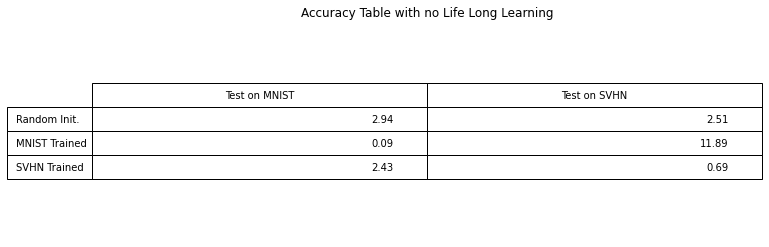

In [ ]:
import matplotlib.pyplot as plt

no_lll_table = np.around(no_lll_table, decimals=2)

columns = ('Test on MNIST', 'Test on SVHN')
rows = ('Random Init.', 'MNIST Trained', 'SVHN Trained')

no_lll = plt.table(cellText=no_lll_table, rowLabels=rows, colLabels=columns,  loc='center')
plt.title('Accuracy Table with no Life Long Learning')
plt.box(on=None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

no_lll.scale(2, 2)
plt.show()

In [ ]:
# Apply EWC
model_ewc = tf.keras.Sequential([
                                    tf.keras.Input(shape=(28, 28, 1)),

                                    tf.keras.layers.Conv2D(8, 3, strides=1, padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(),

                                    tf.keras.layers.Conv2D(16, 3, strides=1, padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(),

                                    tf.keras.layers.Conv2D(32, 3, strides=1, padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])
model_ewc.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
ewc_table = np.zeros(shape=(3, 2))
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

# Results for random initilization
ewc_table[0, 0] = cross_entropy(mnist_test_label, model_ewc(mnist_test_data, training=True)).numpy()
ewc_table[0, 1] = cross_entropy(svhn_test_label, model_ewc(svhn_test_data, training=True)).numpy()

In [ ]:
# Train the 1st task (MNIST)
model_ewc.fit(x=mnist_train_data, y=mnist_train_label, epochs=10)

ewc_table[1, 0] = cross_entropy(mnist_test_label, model_ewc(mnist_test_data, training=True)).numpy()
ewc_table[1, 1] = cross_entropy(svhn_test_label, model_ewc(svhn_test_data, training=True)).numpy()

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4850
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0990
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0692
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0494
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0428
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0291
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0256
Epoch 8/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0217
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0165
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0170


In [ ]:
# Calculate guard parameters for the second task 
task1_variables = model_ewc.trainable_variables.copy()
for i in range(len(task1_variables)):
  task1_variables[i] = tf.constant(task1_variables[i])

with tf.GradientTape() as tape:
  losses = tf.math.log(model_ewc(mnist_train_data[:10000], training=True))

task1_gradient = tape.gradient(losses, model_ewc.trainable_variables)

In [ ]:
guard = [0] * len(task1_gradient)
for i in range(len(task1_gradient)):
  print(tf.shape(task1_gradient[i]))

tf.Tensor([3 3 1 8], shape=(4,), dtype=int32)
tf.Tensor([8], shape=(1,), dtype=int32)
tf.Tensor([8], shape=(1,), dtype=int32)
tf.Tensor([8], shape=(1,), dtype=int32)
tf.Tensor([ 3  3  8 16], shape=(4,), dtype=int32)
tf.Tensor([16], shape=(1,), dtype=int32)
tf.Tensor([16], shape=(1,), dtype=int32)
tf.Tensor([16], shape=(1,), dtype=int32)
tf.Tensor([ 3  3 16 32], shape=(4,), dtype=int32)
tf.Tensor([32], shape=(1,), dtype=int32)
tf.Tensor([32], shape=(1,), dtype=int32)
tf.Tensor([32], shape=(1,), dtype=int32)
tf.Tensor([25088    10], shape=(2,), dtype=int32)
tf.Tensor([10], shape=(1,), dtype=int32)


In [ ]:
for i in range(len(guard)):
  task1_gradient[i] = task1_gradient[i]
  guard[i] = task1_gradient[i] ** 2 / 10000.

In [ ]:
# Define loss function for EWS
def ews_loss(x, y):
  loss = cross_entropy(y, model_ewc(x, training=True))
  for k in range(len(guard)):
    loss += tf.reduce_sum(0.001 * guard[k] * (model_ewc.trainable_variables[k] - task1_variables[k]) ** 2)
  
  return loss

In [ ]:
# Train the model for the 2nd task
epochs = 10
ewc_optimizer = tf.keras.optimizers.Adam()

for i in range(10):
  print('Current epoch is '+str(i))
  for j in range(500):
    x = svhn_train_data[j*100:100*(j+1), :, :, :]
    y = svhn_train_label[j*100:100*(j+1)]

    with tf.GradientTape() as ewc_tape:
      loss_function = ews_loss(x, y)
 
    gradients = ewc_tape.gradient(loss_function, model_ewc.trainable_variables)

    ewc_optimizer.apply_gradients(zip(gradients, model_ewc.trainable_variables))

Current epoch is 0
Current epoch is 1
Current epoch is 2
Current epoch is 3
Current epoch is 4
Current epoch is 5
Current epoch is 6
Current epoch is 7
Current epoch is 8
Current epoch is 9


In [ ]:
# Add results for the 2nd task
ewc_table[2, 0] = cross_entropy(mnist_test_label, model_ewc(mnist_test_data, training=True)).numpy()
ewc_table[2, 1] = cross_entropy(svhn_test_label, model_ewc(svhn_test_data, training=True)).numpy()
print(ewc_table[2, 0])

0.405350923538208


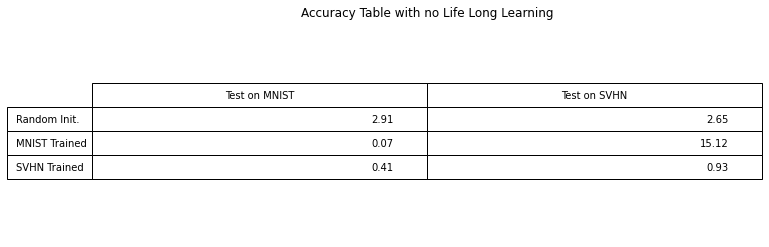

In [ ]:
# Show EWC table
ewc_table = np.around(ewc_table, decimals=2)

ewc = plt.table(cellText=ewc_table, rowLabels=rows, colLabels=columns,  loc='center')
plt.title('Accuracy Table with no Life Long Learning')
plt.box(on=None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ewc.scale(2, 2)
plt.show()